# Install Spark

The below comands will install spark locally in our colab instance.

In [11]:
# Colab: Java + PySpark
!brew update && brew install openjdk@17
%pip install -q pyspark==3.5.4
import os, subprocess
os.environ["JAVA_HOME"] = subprocess.check_output(
    "/usr/libexec/java_home", shell=True
).decode().strip()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("adult-mllib").getOrCreate()
print("Spark:", spark.version)

==> Updating Homebrew...
Already up-to-date.
To reinstall 17.0.17, run:
  brew reinstall openjdk@17
Note: you may need to restart the kernel to use updated packages.
Spark: 3.5.4


## Exercise Overview
In this exercise we will play with Spark [Datasets & Dataframes](https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes), some [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), and build a couple of binary classifiaction models using [Spark ML](https://spark.apache.org/docs/latest/ml-guide.html) (with some [MLlib](https://spark.apache.org/mllib/) too).
<br><br>
The set up and approach will not be too dissimilar to the standard type of approach you might do in [Sklearn](http://scikit-learn.org/stable/index.html). Spark has matured to the stage now where for 90% of what you need to do (when analysisng tabular data) should be possible with Spark dataframes, SQL, and ML libraries. This is where this exerise is mainly trying to focus.  
<br>

#### Links & References

Some useful links and references of sources used in creating this exercise:

**Note**: Right click and open as new tab!
<br>
1. [Latest Spark Docs](https://spark.apache.org/docs/latest/index.html)
1. [Databricks Homepage](https://databricks.com/)
1. [Databricks Community Edition FAQ](https://databricks.com/product/faq/community-edition)
1. [Databricks Self Paced Training](https://databricks.com/training-overview/training-self-paced)
1. [Databricks Notebook Guide](https://docs.databricks.com/user-guide/notebooks/index.html)
1. [Databricks Binary Classification Tutorial](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html#binary-classification)

#### Get Data

Here we will pull in some sample data from the UCI data repository.

Feel free to adapt this notebook later to play around with a different dataset if you like (all available are listed in a cell below).

In [17]:
# try:
#     spark
# except NameError:
#     from pyspark.sql import SparkSession
#     spark = (
#         SparkSession.builder
#         .master("local[*]")
#         .appName("adult-colab")
#         .getOrCreate()
#     )
# import pandas as pd
# cols = [
#     "age","workclass","fnlwgt","education","education_num","marital_status",
#     "occupation","relationship","race","sex","capital_gain","capital_loss",
#     "hours_per_week","native_country","income"
# ]
# pdf = pd.read_csv(
#     "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
#     header=None,
#     names=cols,
#     skipinitialspace=True,
#     na_values=["?", " ?"]
# )
# for c in pdf.select_dtypes(include="object").columns:
#     pdf[c] = pdf[c].str.strip()
# pdf = pdf.dropna().reset_index(drop=True)
# sdf = spark.createDataFrame(pdf)
# spark.sql("CREATE DATABASE IF NOT EXISTS main")
# spark.sql("USE main")
# spark.sql("DROP TABLE IF EXISTS adult")
# sdf.createOrReplaceTempView("adult_src")
# spark.sql("""
# CREATE TABLE adult
# USING PARQUET
# AS SELECT * FROM adult_src
# """)
# spark.sql("CREATE OR REPLACE TEMP VIEW adult AS SELECT * FROM adult")
spark.sql("SELECT COUNT(*) AS n_rows FROM adult").show()
spark.sql("SELECT * FROM adult LIMIT 5").show()

+------+
|n_rows|
+------+
| 30162|
+------+

+---+---------+------+------------+-------------+------------------+-----------------+-------------+-----+----+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|   education|education_num|    marital_status|       occupation| relationship| race| sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+---------+------+------------+-------------+------------------+-----------------+-------------+-----+----+------------+------------+--------------+--------------+------+
| 53|Local-gov|188644|     5th-6th|            3|Married-civ-spouse|    Other-service|      Husband|White|Male|           0|           0|            40|        Mexico| <=50K|
| 28|  Private|136077|        10th|            6|     Never-married|Handlers-cleaners|Not-in-family|White|Male|           0|           0|            40| United-States| <=50K|
| 28|State-gov|119793|Some-college|           10|Married-civ-spouse|  Protectiv

#### Spark SQL
Below we will use Spark SQL to load in the data and then register it as a Dataframe aswell. So the end result will be a Spark SQL table called 'adult' and a Spark Dataframe called 'df_adult'.
<br><br>
This is an example of the flexibility in Spark in that you could do lots of you ETL and data wrangling using either Spark SQL or Dataframes and pyspark. Most of the time it's a case of using whatever you are most comfortable with.
<br><br>
When you get more advanced then you might consider learning about the pro's and con's of each and in what circumstances you might favour one over the other (or operating direclty on RDD's), [here](https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html) is a good article on the issues. For now, no need to overthink it!

In [19]:
# look at the data
spark.sql("SELECT * FROM adult LIMIT 5").show()

+---+---------+------+------------+-------------+------------------+-----------------+-------------+-----+----+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|   education|education_num|    marital_status|       occupation| relationship| race| sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+---------+------+------------+-------------+------------------+-----------------+-------------+-----+----+------------+------------+--------------+--------------+------+
| 53|Local-gov|188644|     5th-6th|            3|Married-civ-spouse|    Other-service|      Husband|White|Male|           0|           0|            40|        Mexico| <=50K|
| 28|  Private|136077|        10th|            6|     Never-married|Handlers-cleaners|Not-in-family|White|Male|           0|           0|            40| United-States| <=50K|
| 28|State-gov|119793|Some-college|           10|Married-civ-spouse|  Protective-serv|      Husband|White|Male|           0| 

If you are more comfortable with SQL then as you can see below, its very easy to just get going with writing standard SQL type code to analyse your data, do data wrangling and create new dataframes.

In [21]:
# Lets get some summary marital status rates by occupation
result = spark.sql(
  """
  SELECT
    occupation,
    SUM(1) as n,
    ROUND(AVG(if(LTRIM(marital_status) LIKE 'Married-%',1,0)),2) as married_rate,
    ROUND(AVG(if(lower(marital_status) LIKE '%widow%',1,0)),2) as widow_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Divorced',1,0)),2) as divorce_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Separated',1,0)),2) as separated_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM
    adult
  GROUP BY 1
  ORDER BY n DESC
  """)
result.show()

+-----------------+----+------------+----------+------------+--------------+-------------+
|       occupation|   n|married_rate|widow_rate|divorce_rate|separated_rate|bachelor_rate|
+-----------------+----+------------+----------+------------+--------------+-------------+
|   Prof-specialty|4038|        0.52|      0.02|        0.13|          0.02|          0.3|
|     Craft-repair|4030|        0.64|      0.01|        0.11|          0.02|         0.21|
|  Exec-managerial|3992|        0.61|      0.02|        0.15|          0.02|          0.2|
|     Adm-clerical|3721|        0.28|      0.04|        0.22|          0.04|         0.42|
|            Sales|3584|        0.46|      0.03|        0.12|          0.03|         0.36|
|    Other-service|3212|        0.24|      0.05|        0.15|          0.06|          0.5|
|Machine-op-inspct|1966|        0.51|      0.03|        0.14|          0.04|         0.29|
| Transport-moving|1572|        0.64|      0.02|        0.11|          0.02|         0.21|

You can easily register dataframes as a table for Spark SQL too. So this way you can easily move between Dataframes and Spark SQL for whatever reason.

In [24]:
# register the df we just made as a table for spark sql
result.createOrReplaceTempView("result")
spark.sql("SELECT * FROM result").show(5)

+---------------+----+------------+----------+------------+--------------+-------------+
|     occupation|   n|married_rate|widow_rate|divorce_rate|separated_rate|bachelor_rate|
+---------------+----+------------+----------+------------+--------------+-------------+
| Prof-specialty|4038|        0.52|      0.02|        0.13|          0.02|          0.3|
|   Craft-repair|4030|        0.64|      0.01|        0.11|          0.02|         0.21|
|Exec-managerial|3992|        0.61|      0.02|        0.15|          0.02|          0.2|
|   Adm-clerical|3721|        0.28|      0.04|        0.22|          0.04|         0.42|
|          Sales|3584|        0.46|      0.03|        0.12|          0.03|         0.36|
+---------------+----+------------+----------+------------+--------------+-------------+
only showing top 5 rows



#### <span style="color:darkblue">Question 1</span>

1. Write some spark sql to get the top 'bachelor_rate' by 'education' group?

In [28]:
### Question 1.1 Answer ###

result =spark.sql(
  """
  SELECT
    education,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM
    adult
  GROUP BY education
  ORDER BY bachelor_rate DESC
  LIMIT 1;
  """)
result.show()

+---------+-------------+
|education|bachelor_rate|
+---------+-------------+
|     12th|         0.54|
+---------+-------------+



#### Spark DataFrames
Below we will create our DataFrame from the SQL table and do some similar analysis as we did with Spark SQL but using the DataFrames API.

In [30]:
# register a df from the sql df
df_adult = spark.table("adult")
cols = df_adult.columns # this will be used much later in the notebook, ignore for now

In [32]:
# look at df schema
df_adult.printSchema()

root
 |-- age: long (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: long (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: long (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: long (nullable = true)
 |-- capital_loss: long (nullable = true)
 |-- hours_per_week: long (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [34]:
# look at the df
df_adult.show(5)

+---+---------+------+------------+-------------+------------------+-----------------+-------------+-----+----+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|   education|education_num|    marital_status|       occupation| relationship| race| sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+---------+------+------------+-------------+------------------+-----------------+-------------+-----+----+------------+------------+--------------+--------------+------+
| 53|Local-gov|188644|     5th-6th|            3|Married-civ-spouse|    Other-service|      Husband|White|Male|           0|           0|            40|        Mexico| <=50K|
| 28|  Private|136077|        10th|            6|     Never-married|Handlers-cleaners|Not-in-family|White|Male|           0|           0|            40| United-States| <=50K|
| 28|State-gov|119793|Some-college|           10|Married-civ-spouse|  Protective-serv|      Husband|White|Male|           0| 

Below we will do a similar calulation to what we did above but using the DataFrames API

In [37]:
# import what we will need
from pyspark.sql.functions import when, col, mean, desc, round

# wrangle the data a bit
df_result = df_adult.select(
  df_adult['occupation'],
  # create a 1/0 type col on the fly
  when( col('marital_status') == ' Divorced' , 1 ).otherwise(0).alias('is_divorced')
)
# do grouping (and a round)
df_result = df_result.groupBy('occupation').agg(round(mean('is_divorced'),2).alias('divorced_rate'))
# do ordering
df_result = df_result.orderBy(desc('divorced_rate'))
# show results
df_result.show(5)

+-----------------+-------------+
|       occupation|divorced_rate|
+-----------------+-------------+
|            Sales|          0.0|
|  Exec-managerial|          0.0|
|   Prof-specialty|          0.0|
|Handlers-cleaners|          0.0|
|  Farming-fishing|          0.0|
+-----------------+-------------+
only showing top 5 rows



As you can see the dataframes api is a bit more verbose then just expressing what you want to do in standard SQL.<br><br>But some prefer it and might be more used to it, and there could be cases where expressing what you need to do might just be better using the DataFrame API if it is too complicated for a simple SQL expression for example of maybe involves recursion of some type.

#### <span style="color:darkblue">Question 2</span>
1. Write some pyspark to get the top 'bachelor_rate' by 'education' group using DataFrame operations?

In [40]:
### Question 2.1 Answer ###

# wrangle the data a bit
df_result = df_adult.select(
  df_adult['education'],
  # create a 1/0 type col on the fly
  when( col('marital_status') == 'Never-married' , 1 ).otherwise(0).alias('is_never_married')
)
# do grouping (and a round)
df_result = df_result.groupBy('education').agg(round(mean('is_never_married'),2).alias('bachelor_rate'))
# do ordering
df_result = df_result.orderBy(desc('bachelor_rate'))
df_result.show(1)

+---------+-------------+
|education|bachelor_rate|
+---------+-------------+
|     12th|         0.54|
+---------+-------------+
only showing top 1 row



#### Explore & Visualize Data
It's very easy to [collect()](https://spark.apache.org/docs/latest/rdd-programming-guide.html#printing-elements-of-an-rdd) your Spark DataFrame data into a Pandas df and then continue to analyse or plot as you might normally.
<br><br>
Obviously if you try to collect() a huge DataFrame then you will run into issues, so usually you would only collect aggregated or sampled data into a Pandas df.

In [53]:
import pandas as pd

# do some analysis
result = spark.sql(
  """
  SELECT
    occupation,
    AVG(IF(income = '>50K',1,0)) as plus_50k
  FROM
    adult
  GROUP BY 1
  ORDER BY 2 DESC
  """)

# collect results into a pandas df
df_pandas = pd.DataFrame(
  result.collect(),
  columns=result.schema.names
)

# look at df
print(df_pandas.head())

        occupation  plus_50k
0  Exec-managerial  0.485220
1   Prof-specialty  0.448489
2  Protective-serv  0.326087
3     Tech-support  0.304825
4            Sales  0.270647


In [55]:
print(df_pandas.describe())

        plus_50k
count  14.000000
mean    0.204209
std     0.147293
min     0.006993
25%     0.112403
50%     0.168381
75%     0.296280
max     0.485220


In [57]:
print(df_pandas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   occupation  14 non-null     object 
 1   plus_50k    14 non-null     float64
dtypes: float64(1), object(1)
memory usage: 356.0+ bytes
None


Here we will just do some very basic plotting to show how you might collect what you are interested in into a Pandas DF and then just plot any way you normally would.

For simplicity we are going to use the plotting functionality built into pandas (you could make this a pretty as you want).

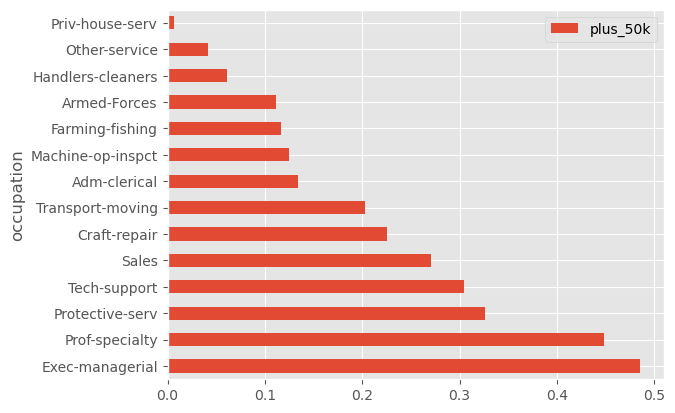

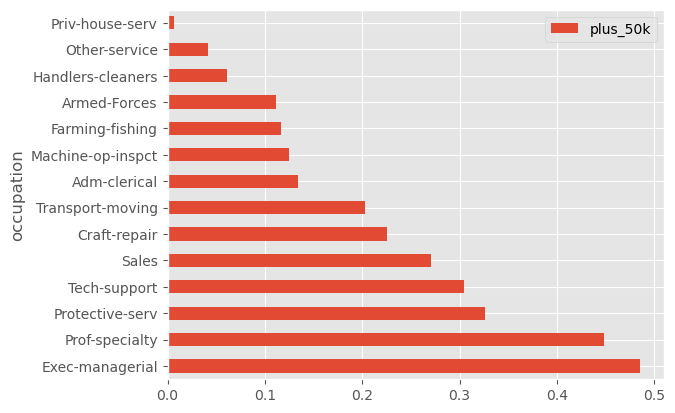

In [60]:
import matplotlib.pyplot as plt

# i like ggplot style
plt.style.use('ggplot')

# get simple plot on the pandas data
myplot = df_pandas.plot(kind='barh', x='occupation', y='plus_50k')

# display the plot (note - display() is a databricks function -
# more info on plotting in Databricks is here: https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html)
display(myplot.figure)

You can also easily get summary stats on a Spark DataFrame like below. [Here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html) is a nice blog post that has more examples.<br><br>So this is an example of why you might want to move from Spark SQL into DataFrames API as being able to just call describe() on the Spark DF is easier then trying to do the equivilant in Spark SQL.

In [63]:
# describe df
df_adult.select(df_adult['age'],df_adult['education_num']).describe().show()

+-------+------------------+------------------+
|summary|               age|     education_num|
+-------+------------------+------------------+
|  count|             30162|             30162|
|   mean|38.437901995888865| 10.12131158411246|
| stddev|13.134664776855988|2.5499949188567332|
|    min|                17|                 1|
|    max|                90|                16|
+-------+------------------+------------------+



### ML Pipeline - Logistic Regression vs Random Forest

Below we will create two [Spark ML Pipelines](https://spark.apache.org/docs/latest/ml-pipeline.html) - one that fits a logistic regression and one that fits a random forest. We will then compare the performance of each.

**Note**: A lot of the code below is adapted from [this example](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html).

In [66]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
stages = [] # stages in our Pipeline

for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [68]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

In [70]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [72]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
pipelineModel = pipeline.fit(df_adult)
dataset = pipelineModel.transform(df_adult)
# Keep relevant columns
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)
dataset.show()

25/11/24 23:04:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+--------------------+---+----------------+------+------------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|label|            features|age|       workclass|fnlwgt|   education|education_num|    marital_status|       occupation| relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+-----+--------------------+---+----------------+------+------------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|  0.0|(96,[2,19,21,32,4...| 53|       Local-gov|188644|     5th-6th|            3|Married-civ-spouse|    Other-service|      Husband|White|  Male|           0|           0|            40|        Mexico| <=50K|
|  0.0|(96,[0,13,22,35,4...| 28|         Private|136077|        10th|            6|     Never-married|Handlers-cleaners|Not-in-family|White|  Male|         

In [74]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

20998
9164


In [76]:
from pyspark.sql.functions import avg

# get the rate of the positive outcome from the training data to use as a threshold in the model
training_data_positive_rate = trainingData.select(avg(trainingData['label'])).collect()[0][0]

print("Positive rate in the training data is {}".format(training_data_positive_rate))

Positive rate in the training data is 0.2480712448804648


#### Logistic Regression - Train

In [79]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# set threshold for the probability above which to predict a 1
lr.setThreshold(training_data_positive_rate)
# lr.setThreshold(0.5) # could use this if knew you had balanced data

# Train model with Training Data
lrModel = lr.fit(trainingData)

# get training summary used for eval metrics and other params
lrTrainingSummary = lrModel.summary

# Find the best model threshold if you would like to use that instead of the empirical positve rate
fMeasure = lrTrainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
lrBestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']

print("Best threshold based on model performance on training data is {}".format(lrBestThreshold))

25/11/24 23:04:25 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/11/24 23:04:25 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Best threshold based on model performance on training data is 0.3279827637907373


#### GBM - Train

#### <span style="color:darkblue">Question 3</span>
1. Train a GBTClassifier on the training data, call the trained model 'gbModel'

In [87]:
### Question 3.1 Answer ###
from pyspark.ml.classification import GBTClassifier
# Create initial GBTClassifier model
gb = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
gbModel = gb.fit(trainingData)

#### Logistic Regression - Predict

In [89]:
# make predictions on test data
lrPredictions = lrModel.transform(testData)

# display predictions
lrPredictions.select("label", "prediction", "probability").show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       1.0|[0.71777320596013...|
|  0.0|       1.0|[0.47726939746035...|
|  0.0|       1.0|[0.39379752705203...|
|  0.0|       1.0|[0.42825180708204...|
|  0.0|       1.0|[0.36240973732236...|
|  0.0|       1.0|[0.51295279270827...|
|  0.0|       1.0|[0.44923627642044...|
|  0.0|       0.0|[0.82476470846039...|
|  0.0|       0.0|[0.85698923788268...|
|  0.0|       1.0|[0.67684691383086...|
|  0.0|       0.0|[0.77060694848759...|
|  0.0|       0.0|[0.80196096512685...|
|  0.0|       0.0|[0.79986178972958...|
|  0.0|       0.0|[0.77932578336670...|
|  0.0|       0.0|[0.82559414173705...|
|  0.0|       0.0|[0.79204922511386...|
|  0.0|       0.0|[0.77233798121519...|
|  0.0|       0.0|[0.78728075975432...|
|  0.0|       1.0|[0.72772983513384...|
|  0.0|       1.0|[0.75077088663024...|
+-----+----------+--------------------+
only showing top 20 rows



### GBM - Predict

#### <span style="color:darkblue">Question 4</span>
1. Get predictions on the test data for your GBTClassifier. Call the predictions df 'gbPredictions'.

In [92]:
### Question 4.1 Answer ###

# make predictions on test data
gbPredictions = gbModel.transform(testData)

gbPredictions.show()

+-----+--------------------+---+---------+------+---------+-------------+------------------+--------------+------------+-----+------+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|label|            features|age|workclass|fnlwgt|education|education_num|    marital_status|    occupation|relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|       rawPrediction|         probability|prediction|
+-----+--------------------+---+---------+------+---------+-------------+------------------+--------------+------------+-----+------+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|  0.0|(96,[0,6,21,27,40...| 32|  Private|131224|  HS-grad|            9|Married-civ-spouse|Prof-specialty|     Husband|White|  Male|           0|           0|            40| United-States| <=50K|[0.58379197821037...|[0.76270802688106...|       0.0|


#### Logistic Regression - Evaluate

#### <span style="color:darkblue">Question 5</span>
1. Complete the print_performance_metrics() function below to also include measures of F1, Precision, Recall, False Positive Rate and True Positive Rate.

In [100]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

def print_performance_metrics(predictions):
  # Evaluate model
  evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
  auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
  aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
  print("auc = {}".format(auc))
  print("aupr = {}".format(aupr))

  # get rdd of predictions and labels for mllib eval metrics
  predictionAndLabels = predictions.select("prediction","label").rdd

  # Instantiate metrics objects
  binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
  multi_metrics = MulticlassMetrics(predictionAndLabels)

  # Area under precision-recall curve
  print("Area under PR = {}".format(binary_metrics.areaUnderPR))
  # Area under ROC curve
  print("Area under ROC = {}".format(binary_metrics.areaUnderROC))
  # Accuracy
  print("Accuracy = {}".format(multi_metrics.accuracy))
  # Confusion Matrix
  print(multi_metrics.confusionMatrix())

  ### Question 5.1 Answer ###

  # F1 score (for label 1)
  print("F1 = {}".format(multi_metrics.fMeasure(1.0)))
  # Precision (for label 1)
  print("Precision = {}".format(multi_metrics.precision(1.0)))
  # Recall (for label 1)
  print("Recall = {}".format(multi_metrics.recall(1.0)))
  # FPR (False Positive Rate for label 1)
  print("FPR = {}".format(multi_metrics.falsePositiveRate(1.0)))
  # TPR (True Positive Rate is the same as recall)
  print("TPR = {}".format(multi_metrics.recall(1.0)))


print_performance_metrics(lrPredictions)

auc = 0.8990241173289499
aupr = 0.7625004137324467


/opt/anaconda3/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Area under PR = 0.5483916751972965
Area under ROC = 0.8146564879692142
Accuracy = 0.8037974683544303
DenseMatrix([[5443., 1422.],
             [ 376., 1923.]])
F1 = 0.6814316087880935
Precision = 0.5748878923766816
Recall = 0.8364506307090039
FPR = 0.20713765477057539
TPR = 0.8364506307090039


#### GBM - Evaluate

In [102]:
print_performance_metrics(gbPredictions)

auc = 0.8957259038177083
aupr = 0.7616807964549456


/opt/anaconda3/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Area under PR = 0.643112289655457
Area under ROC = 0.7451871946604607
Accuracy = 0.8427542557835006
DenseMatrix([[6460.,  405.],
             [1036., 1263.]])
F1 = 0.6367532140156289
Precision = 0.7571942446043165
Recall = 0.5493692909960852
FPR = 0.05899490167516387
TPR = 0.5493692909960852


## Cross Validation

For each model you can run the below comand to see its params and a brief explanation of each.

In [104]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [106]:
print(gb.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

#### Logisitic Regression - Param Grid

In [109]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
lrParamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [2, 5])
             .build())

#### GBM - Param Grid

#### <span style="color:darkblue">Question 6</span>
1. Build out a param grid for the gb model, call it 'gbParamGrid'.

In [138]:
### Question 6.1 Answer ###
# Create ParamGrid for Cross Validation
gbParamGrid = paramGrid = (ParamGridBuilder()
             .addGrid(gb.maxDepth, [2,3,4])
             .addGrid(gb.maxIter, [5,10])
             .build())

#### Logistic Regression - Perform Cross Validation

In [117]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
lrCv = CrossValidator(estimator=lr, estimatorParamMaps=lrParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
lrCvModel = lrCv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [118]:
# below approach to getting at the best params from the best cv model taken from:
# https://stackoverflow.com/a/46353730/1919374

# look at best params from the CV
print(lrCvModel.bestModel._java_obj.getRegParam())
print(lrCvModel.bestModel._java_obj.getElasticNetParam())
print(lrCvModel.bestModel._java_obj.getMaxIter())

0.01
0.5
5


#### GBM - Perform Cross Validation

#### <span style="color:darkblue">Question 7</span>
1. Perform cross validation of params on your 'gb' model.
1. Print out the best params you found.

In [140]:
### Question 7.1 Answer ###

# Create CrossValidator
gbCv = CrossValidator(estimator=gb,
                    estimatorParamMaps=gbParamGrid,
                    evaluator=evaluator,
                    numFolds=2)

# Run cross validations
gbCvModel = gbCv.fit(trainingData)

25/11/25 00:08:56 WARN CacheManager: Asked to cache already cached data.
25/11/25 00:08:56 WARN CacheManager: Asked to cache already cached data.


In [142]:
### Question 7.2 Answer ###

# look at best params from the CV
bestModel = gbCvModel.bestModel
print("Best maxDepth: ", bestModel.getMaxDepth())
print("Best maxIter: ", bestModel.getMaxIter())

Best maxDepth:  4
Best maxIter:  10


#### Logistic Regression - CV Model Predict

In [145]:
# Use test set to measure the accuracy of our model on new data
lrCvPredictions = lrCvModel.transform(testData)

lrCvPredictions.show()

+-----+--------------------+---+---------+------+---------+-------------+------------------+--------------+------------+-----+------+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|label|            features|age|workclass|fnlwgt|education|education_num|    marital_status|    occupation|relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|       rawPrediction|         probability|prediction|
+-----+--------------------+---+---------+------+---------+-------------+------------------+--------------+------------+-----+------+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|  0.0|(96,[0,6,21,27,40...| 32|  Private|131224|  HS-grad|            9|Married-civ-spouse|Prof-specialty|     Husband|White|  Male|           0|           0|            40| United-States| <=50K|[0.83934095855646...|[0.69832639610512...|       1.0|


#### GBM - CV Model Predict

In [148]:
gbCvPredictions = gbCvModel.transform(testData)

gbCvPredictions.show()

+-----+--------------------+---+---------+------+---------+-------------+------------------+--------------+------------+-----+------+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|label|            features|age|workclass|fnlwgt|education|education_num|    marital_status|    occupation|relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|       rawPrediction|         probability|prediction|
+-----+--------------------+---+---------+------+---------+-------------+------------------+--------------+------------+-----+------+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|  0.0|(96,[0,6,21,27,40...| 32|  Private|131224|  HS-grad|            9|Married-civ-spouse|Prof-specialty|     Husband|White|  Male|           0|           0|            40| United-States| <=50K|[0.53859661266249...|[0.74596245990083...|       0.0|


#### Logistic Regression - CV Model Evaluate

In [151]:
print_performance_metrics(lrCvPredictions)

auc = 0.8927125920354875
aupr = 0.7395088358584428


/opt/anaconda3/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Area under PR = 0.5241223446276909
Area under ROC = 0.8102266826800467
Accuracy = 0.7843736359668267
DenseMatrix([[5206., 1659.],
             [ 317., 1982.]])
F1 = 0.6673400673400675
Precision = 0.544355946168635
Recall = 0.8621139625924314
FPR = 0.24166059723233796
TPR = 0.8621139625924314


#### GBM - CV Model Evaluate

In [154]:
print_performance_metrics(gbCvPredictions)

auc = 0.893136000420716
aupr = 0.7590144399010086


/opt/anaconda3/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Area under PR = 0.6372331751557797
Area under ROC = 0.7405461445443046
Accuracy = 0.8401353120907901
DenseMatrix([[6456.,  409.],
             [1056., 1243.]])
F1 = 0.6292077954948114
Precision = 0.7524213075060533
Recall = 0.5406698564593302
FPR = 0.05957756737072105
TPR = 0.5406698564593302


#### Logistic Regression - Model Explore

In [157]:
print('Model Intercept: ', lrCvModel.bestModel.intercept)

Model Intercept:  -6.48907984116131


In [159]:
lrWeights = lrCvModel.bestModel.coefficients
lrWeights = [(float(w),) for w in lrWeights]  # convert numpy type to float, and to tuple
lrWeightsDF = spark.createDataFrame(lrWeights, ["Feature Weight"])
lrWeightsDF.show()

+--------------------+
|      Feature Weight|
+--------------------+
| 0.05825006825791062|
|-0.14100830520138363|
|                 0.0|
|                 0.0|
| 0.18091656397059191|
| 0.35870700524591126|
|-0.07135159718988875|
|                 0.0|
|  0.3927263574832894|
|  0.5468578288480036|
|                 0.0|
|-0.11288927013827567|
|                 0.0|
|-0.20199723415137424|
| -0.3006963788574715|
|  0.8672855474408445|
|-0.06151253438791832|
|                 0.0|
| 0.47966223092620536|
|                 0.0|
+--------------------+
only showing top 20 rows



### Feature Importance

#### <span style="color:darkblue">Question 8</span>
1. Print out a table of feature_name and feature_coefficient from the Logistic Regression model.
<br><br>
Hint: Adapt the code from here: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

In [178]:
### Question 8.1 Answer ###

# from: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

def get_feature_names(assembler, ohe_model=None):
    """
    Get a list of feature names in the assembled vector
    """
    feature_names = []
    
    for col in assembler.getInputCols():
        # if column is numeric
        if "_vec" not in col:
            feature_names.append(col)
        else:
            # for OHE vector, get the category names
            size = ohe_model.categorySizes[assembler.getInputCols().index(col)]
            feature_names += [f"{col}_{i}" for i in range(size)]
    
    return feature_names
coefficients = lrModel.coefficients.toArray()
feature_names = get_feature_names(assembler, encoder)

for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef}")

workclassclassVec: 0.10975294333318489
educationclassVec: -0.32377657537886584
marital_statusclassVec: -0.14648625873209664
occupationclassVec: -0.11168809945861524
relationshipclassVec: 0.2524743520138755
raceclassVec: 0.5891890942494925
sexclassVec: -0.14067716649139755
native_countryclassVec: 0.049508100537743106
age: 0.39898643111436566
fnlwgt: 0.678659856326334
education_num: 0.05461426575271452
capital_gain: -0.6773139792442014
capital_loss: -0.21339270848173894
hours_per_week: -0.7867748168717759


In [174]:
gbCvFeatureImportance = gbCvModel.bestModel.featureImportances.toArray()
for name, importance in zip(feature_names, gbCvFeatureImportance):
    print(f"{name}: {importance}")

workclassclassVec: 0.0015094581675379262
educationclassVec: 0.011058352686898825
marital_statusclassVec: 0.0021407743228938686
occupationclassVec: 0.0
relationshipclassVec: 0.0
raceclassVec: 0.0
sexclassVec: 0.0011707759993803935
native_countryclassVec: 0.0
age: 0.010348971330838012
fnlwgt: 0.0
education_num: 0.0
capital_gain: 0.0
capital_loss: 0.0006809502258721518
hours_per_week: 0.0


#### <span style="color:darkblue">Question 9</span>
1. Build and train a RandomForestClassifier and print out a table of feature importances from it.

In [190]:
### Question 9.1 Answer ###

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier

# Train RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50)
rf_model = rf.fit(dataset)

# Extract feature names from metadata
meta = dataset.schema["features"].metadata
attrs = []
for i, attr in enumerate(
    meta["ml_attr"]["attrs"].get("numeric", []) +
    meta["ml_attr"]["attrs"].get("binary", []) +
    meta["ml_attr"]["attrs"].get("categorical", [])
):
    attrs.append((i, attr["name"]))

# Build feature importance table
importances = rf_model.featureImportances.toArray()
rf_feature_importance = pd.DataFrame(
    [(name, importances[idx]) for idx, name in attrs],
    columns=["feature_name", "feature_importance"]
).sort_values(by="feature_importance", ascending=False)

# Display table
print(rf_feature_importance)


                                         feature_name  feature_importance
93                     native_countryclassVec_Hungary            0.167279
21                      educationclassVec_Prof-school            0.161550
92  native_countryclassVec_Outlying-US(Guam-USVI-etc)            0.149373
40                occupationclassVec_Transport-moving            0.091994
90                    native_countryclassVec_Thailand            0.079793
..                                                ...                 ...
64                        native_countryclassVec_Cuba            0.000000
75                      native_countryclassVec_Poland            0.000000
74                    native_countryclassVec_Columbia            0.000000
72                   native_countryclassVec_Guatemala            0.000000
86                        native_countryclassVec_Hong            0.000000

[96 rows x 2 columns]
